Download the data into it's own folder (**data**) and read it in from there so we don't need a network connection to get at it later.  Set <code>stringsAsFactors = FALSE</code> because we'll do this manually ourselves.

In [41]:
# get the training data here: https://www.kaggle.com/c/titanic/data/train.csv
#data_all <- read.csv("../data/titanic_train.csv", na.strings = c("NA", ""), stringsAsFactors = FALSE)
data_all <- read.csv("https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/data/titanic_train.csv", na.strings = c("NA", ""), stringsAsFactors = FALSE)
head(data_all)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


Looks like there is some missing data that we'll need to deal with.  Let's start by determining the numer of missing values in each field.

In [42]:
na_count <- sapply(data_all, function(y) sum(length(which(is.na(y)))))
na_count <- data.frame(na_count)
na_count

,na_count
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Let's take a quick look at **Survival** by **Sex** and **Pclass**.

In [43]:
# Factorize the discrete variables
data_all$Survived <- factor(data_all$Survived)
data_all$Sex <- factor(data_all$Sex)
data_all$Pclass <- factor(data_all$Pclass)
sort(unique(data_all$Pclass))
nrow(data_all)

[1] 1 2 3
Levels: 1 2 3

[1] 891

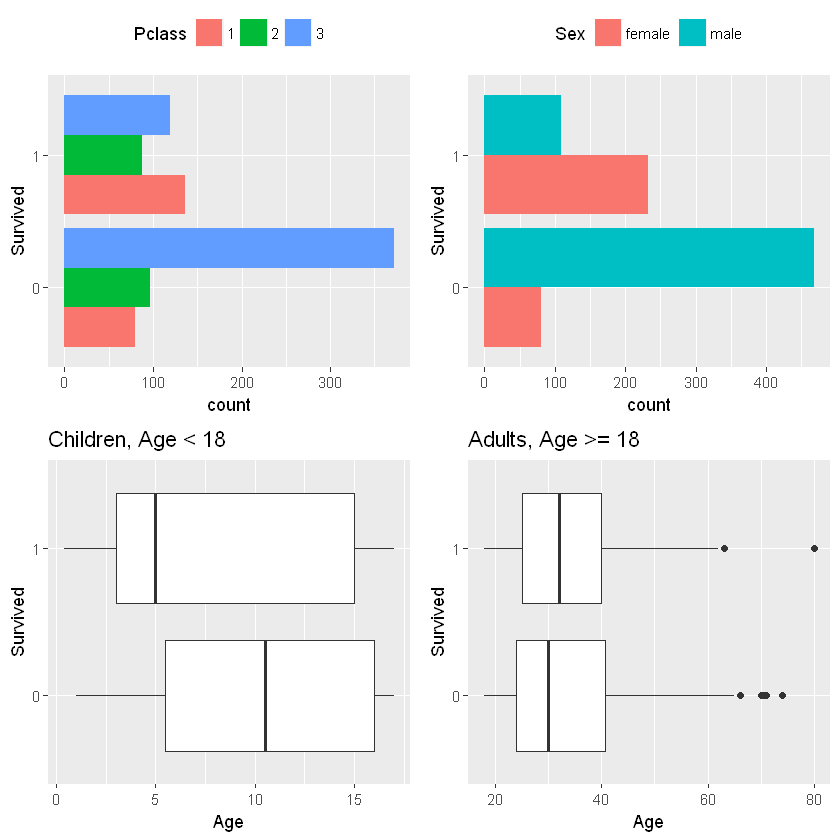

In [44]:
source("PlotTools.R")
# magic commands are an ipython kernel thing and don't work in an R notebook...
#%%R -i df -w 800 -h 480 -u px
# Make class barplot
suppressMessages(suppressWarnings(library(ggplot2)))
library(ggplot2)
p0 <- ggplot(data_all, aes(Survived))
options(jupyter.plot_mimetypes = 'image/png')
p1 <- p0 + geom_bar(aes(fill = Pclass), position = "dodge") + coord_flip()
p1 <- p1 + theme(legend.position = "top")
#p <- p + ggtitle(sprintf("Mime type = '%s'", getOption("jupyter.plot_mimetypes")))
#print(p1)

# Was the old adage "women and children first" was being followed?  First, women...
p2 <- p0 + geom_bar(aes(fill = Sex), position = "dodge") + coord_flip()
p2 <- p2 + theme(legend.position = "top")
#print(p2)

# Next, adults
suppressMessages(suppressWarnings(library(dplyr)))
library(dplyr)
data_age <- filter(data_all, !is.na(Age))
p3 <- ggplot(filter(data_age, Age >= 18), aes(x = Survived, y = Age))
p3 <- p3 + geom_boxplot() + coord_flip()
p3 <- p3 + ggtitle("Adults, Age >= 18")
#print(p3)

# Now, children...
data_kids <- filter(data_age, Age < 18)
p4 <- ggplot(data_kids, aes(x = Survived, y = Age))
p4 <- p4 + geom_boxplot() + coord_flip()
p4 <- p4 + ggtitle("Children, Age < 18")
#print(p4)

multiplot(p1, p4, p2, p3, cols=2)

Being in 1st class and being female appear to enhance probability of survival.  The impact of age appears to be more sublte.  If we look at distributions of adults and children separately, we see some separation.  Need to drill into this further, but for now, let's build a baseline model using LDA using and k-Fold Cross-Validation.  

We have 891 - 177 = 714 records that have *Pclass*, *Sex*, and *Age*.  Let's get all the records that have these three variable populated.

In [45]:
library(dplyr)
data_class_sex_age <- filter(data_all, !is.na(Pclass) & !is.na(Sex) & !is.na(Age))
nrow(data_class_sex_age)

[1] 714

In [47]:
library(caret)
library(e1071)
set.seed(711)
# We have lots of data, so let's do and 80-20 split on the data.
in_train <- createDataPartition(y=data_class_sex_age$Survived, p=0.8, list=FALSE)  # get indices of training set
data_mod01_training <- data_class_sex_age[in_train,]
data_mod01_test <- data_class_sex_age[-in_train,]
#c(nrow(data_mod01_training), nrow(data_mod01_test))
mod01_lda <- train(Survived ~ Age + Pclass + Sex, method='lda', data=data_mod01_training)
mod01_test_results <- predict(mod01_lda, newdata=data_mod01_test)
mod01_acc <- sum(mod01_test_results == data_mod01_test$Survived) / nrow(data_mod01_test)
mod01_acc

[1] 0.7183099